# Pytorch Training Tutorial

In [1]:
import timm
import torch
import numpy as np
import scipy.io as sio
import torch.nn.functional as F
import torch.nn
import time
from tqdm import tqdm

import torchvision
from torchvision import datasets
from torchvision import transforms as T 
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

import torchsummary

import copy

from timm.data import Mixup
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy

import albumentations as A
from albumentations.pytorch import ToTensorV2

c:\Users\user\anaconda3\envs\Capsule\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.__version__)

1.13.1


In [6]:
config={    
    'data_test_dir': r'D:\Coding\dataset\gender_kaggle\Test',
    'data_train_dir': r'D:\Coding\dataset\gender_kaggle\Train',
    'data_single_dir': r'D:\Coding\dataset\flowers',
    
    'batch_size':64,
    'num_classes':5 ,
    'epochs': 300
    }

In [7]:
'''
Torch Transform -> Data Augmentation
'''
transform = {
    'train': T.Compose([
        #T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        # T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
        # T.RandomAffine(degrees=15, translate=(0.2, 0.2),scale=(0.8, 1.2), shear=15),
        # T.RandomHorizontalFlip(),
        # T.RandomVerticalFlip(),
        # T.RandomRotation(10),
        T.RandAugment(num_ops = 9, magnitude = 3),
        T.Resize((224,224)),
        #T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        T.ToTensor(),
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        T.RandomErasing(p=0.25, value='random')
    ]),
    'val': T.Compose([
        T.Resize((224,224)),
        T.ToTensor(),
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) ]),
    }

In [15]:
'''

각각 Train / Test가 따로 폴더로 존재할 때,

ImageFolder : 실제로 불러오는 것은 파일별 경로 및 레이블
Dataset Shape -> dataset[data_index][0]:label, dataset[data_index][1]:image
테스트 데이터셋과 트레이닝 데이터셋을 따로 불러옴
'''
train_ds = datasets.ImageFolder(root=config['data_train_dir'], transform =transform['train'])
test_ds = datasets.ImageFolder(root=config['data_test_dir'], transform =transform['val'])

'''
DataLoader : 데이터로더는 데이터셋을 배치 단위로 불러올 수 있게 해주는 역할 -> 경로를 기반으로 실제로 데이터를 배치단위로 불러옴

sampler -> 샘플 인덱스 지정해주는 역할 (이전의 SubsetRandomSampler의 결과가 인풋)
shuffle -> 셔플링 여부 
둘중에 하나만 쓰는 것이 좋음
num_workers -> 멀티프로세싱을 몇개로 해줄지: 0이면 싱글프로세싱, 주로 CPU 개수 만큼 설정합니다
'''
train_loader = DataLoader(train_ds, batch_size=config['batch_size'],sampler=None ,shuffle=True, num_workers=2)
val_loader = DataLoader(test_ds, batch_size=config['batch_size'],sampler=None,shuffle=True, num_workers=2)
class_names = train_ds.classes

In [8]:
# 트레이닝 데이터셋만 있을 경우 ImageFolder에서 train_ds만 불러온 후
# Subsampler을 활용하여 검증 데이터셋과 트레이닝 데이터셋, 테스트 데이터셋으로 나눔

def get_sampler(data_len, val):
    # data_len 은 트레이닝 데이터셋의 길이
    valid_size = val
    data_len = data_len


    indices = list(range(data_len)) # 전체 인덱스
    np.random.shuffle(indices)

    split = int(np.floor(valid_size * data_len))
    train_idx, valid_idx,test_idx = indices[:-split*2], indices[-split*2:-split], indices[-split:]

    # trainning, validation batch를 얻기 위한 sampler정의
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    train_len = len(train_idx)
    val_len = len(valid_idx)
    test_len = len(test_idx)

    return train_sampler, valid_sampler, test_sampler, train_len, val_len, test_len


In [9]:
train_ds = datasets.ImageFolder(root=config['data_single_dir'], transform =transform['train'])

train_idx, valid_idx, test_idx, train_len, val_len, test_len = get_sampler(data_len=len(train_ds), val=0.1)
train_loader = DataLoader(train_ds, batch_size=config['batch_size'], sampler=train_idx ,shuffle=False, num_workers=0)
val_loader = DataLoader(train_ds, batch_size=config['batch_size'], sampler=valid_idx, shuffle=False, num_workers=0)
class_names = train_ds.classes

In [10]:
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

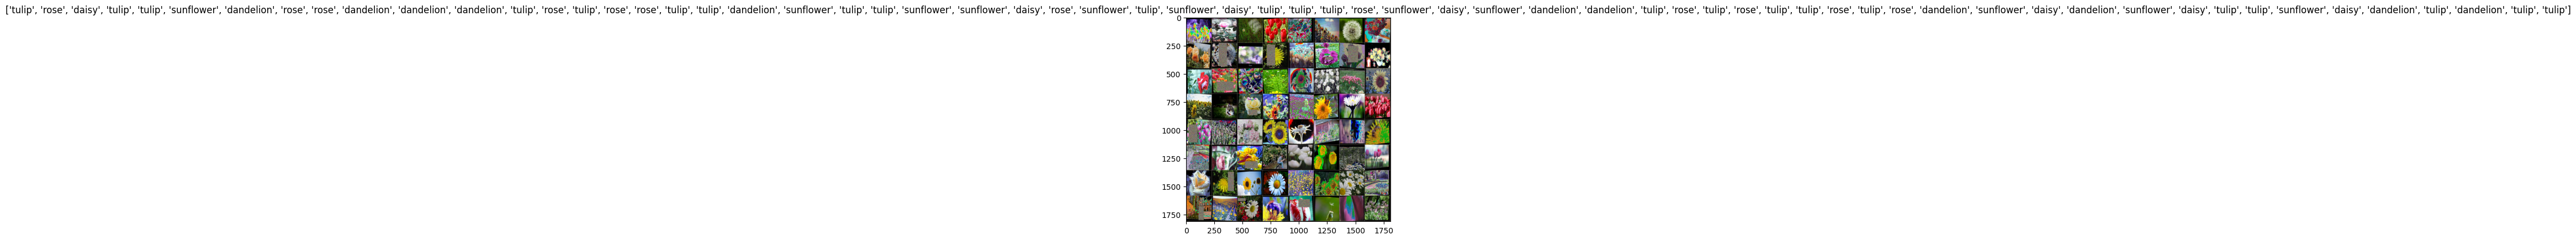

In [11]:
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [12]:
# 허깅페이스 사전학습 모델 로딩
model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=config['num_classes'])

In [13]:
# 가장 간단한 형태의 병렬화
#model =  torch.nn.DataParallel(model,device_ids=[0,1])

'''
모델 병렬학습 코드
1. torch.nn.DataParallel : 

장점: 정말 간단

단점 : DataParallel은 쓰레드간 GIL 경합, 복제 모델의 반복 당 생성, 산란 입력 및 수집 출력으로 인한 추가적인 오버헤드로 인해 
단일 시스템에서도 istributedDataParallel보다 느립니다. 또한 

2. torch.nn.DistributedDataParallel : 다중 작업이며 단일 및 다중 기기 학습을 전부 지원

장점: 빠르다
단점 : 추가적인 함수 작성 필요
-> 여러 개의 GPU에서 딥러닝을 실행하려면, 모델을 복사해서 각  GPU에 할당해야한다. 
-> 그 뒤 batchsize를 batch_size/num_gpu만큼 나눈다. 이것을 scatter 한다고 표현한다. (실제로 scatter 함수가 있다.)

각 GPU에서 모델이 입력을 받아 출력하는 것을 forward 한다고 표현하고, 이 출력들을 하나의 GPU로 모은다. 이렇게 여러 tensor들(출력들)을 하나의 device로 모으는 것을 gather라고 한다.
'''

# model 을 GPU로 올림 model.to('cuda')와 동일
model.cuda()

# 모델 요약 정보
# DataParallel을 사용하면 요약 시 모델사이즈가 GPU 병렬사용 갯수만큼 커짐
torchsummary.summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 384, 14, 14]         295,296
          Identity-2             [-1, 196, 384]               0
        PatchEmbed-3             [-1, 196, 384]               0
           Dropout-4             [-1, 197, 384]               0
          Identity-5             [-1, 197, 384]               0
          Identity-6             [-1, 197, 384]               0
         LayerNorm-7             [-1, 197, 384]             768
            Linear-8            [-1, 197, 1152]         443,520
          Identity-9           [-1, 6, 197, 64]               0
         Identity-10           [-1, 6, 197, 64]               0
          Dropout-11          [-1, 6, 197, 197]               0
           Linear-12             [-1, 197, 384]         147,840
          Dropout-13             [-1, 197, 384]               0
        Attention-14             [-1, 1

In [64]:
# timm.list_models('*resnet*') 이런 식으로 사전학습 가능 모델 검색
resnet_model_list = timm.list_models('*resnet*')
print(resnet_model_list)

['cspresnet50', 'cspresnet50d', 'cspresnet50w', 'eca_resnet33ts', 'ecaresnet26t', 'ecaresnet50d', 'ecaresnet50d_pruned', 'ecaresnet50t', 'ecaresnet101d', 'ecaresnet101d_pruned', 'ecaresnet200d', 'ecaresnet269d', 'ecaresnetlight', 'gcresnet33ts', 'gcresnet50t', 'inception_resnet_v2', 'lambda_resnet26rpt_256', 'lambda_resnet26t', 'lambda_resnet50ts', 'legacy_seresnet18', 'legacy_seresnet34', 'legacy_seresnet50', 'legacy_seresnet101', 'legacy_seresnet152', 'nf_ecaresnet26', 'nf_ecaresnet50', 'nf_ecaresnet101', 'nf_resnet26', 'nf_resnet50', 'nf_resnet101', 'nf_seresnet26', 'nf_seresnet50', 'nf_seresnet101', 'resnet10t', 'resnet14t', 'resnet18', 'resnet18d', 'resnet26', 'resnet26d', 'resnet26t', 'resnet32ts', 'resnet33ts', 'resnet34', 'resnet34d', 'resnet50', 'resnet50_gn', 'resnet50c', 'resnet50d', 'resnet50s', 'resnet50t', 'resnet51q', 'resnet61q', 'resnet101', 'resnet101c', 'resnet101d', 'resnet101s', 'resnet152', 'resnet152c', 'resnet152d', 'resnet152s', 'resnet200', 'resnet200d', 'resn

In [65]:
# 허깅페이스 사전학습 모델 종류 

pretrained_model_list = timm.list_models(pretrained=True)

print(pretrained_model_list)

['bat_resnext26ts.ch_in1k', 'beit_base_patch16_224.in22k_ft_in22k', 'beit_base_patch16_224.in22k_ft_in22k_in1k', 'beit_base_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_224.in22k_ft_in22k', 'beit_large_patch16_224.in22k_ft_in22k_in1k', 'beit_large_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_512.in22k_ft_in22k_in1k', 'beitv2_base_patch16_224.in1k_ft_in1k', 'beitv2_base_patch16_224.in1k_ft_in22k', 'beitv2_base_patch16_224.in1k_ft_in22k_in1k', 'beitv2_large_patch16_224.in1k_ft_in1k', 'beitv2_large_patch16_224.in1k_ft_in22k', 'beitv2_large_patch16_224.in1k_ft_in22k_in1k', 'botnet26t_256.c1_in1k', 'caformer_b36.sail_in1k', 'caformer_b36.sail_in1k_384', 'caformer_b36.sail_in22k', 'caformer_b36.sail_in22k_ft_in1k', 'caformer_b36.sail_in22k_ft_in1k_384', 'caformer_m36.sail_in1k', 'caformer_m36.sail_in1k_384', 'caformer_m36.sail_in22k', 'caformer_m36.sail_in22k_ft_in1k', 'caformer_m36.sail_in22k_ft_in1k_384', 'caformer_s18.sail_in1k', 'caformer_s18.sail_in1k_384', 'caformer_s

In [14]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}

# 데이터셋 사이즈  
# 폴더가 분리되어 있는 경우 len(train_ds)로도 가능
# 폴더가 합쳐져있는 경우 get sampler에서 리턴받은 train_len,val_len으로 가능 
dataset_sizes = {
    # "train": len(train_ds),
    # "val": len(test_ds)
    "train": train_len,
    "val": val_len
}

In [23]:
from timm import optim, scheduler

# 최신 논문 구현에서는 Train one epoch, Validate one epoch 함수를 반복하는 형태로 진행
# 제가 한 구현은 Train/validate 모두 하나의 함수에서 진행

# GPU 사용 여부
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_model(model, criterion, mix_up=True, num_epochs=config['epochs']):
    
    since = time.time() # 시작 시간
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    '''
    Transformer 학습은 AdamW, CosineLRS를 사용하는 것이 좋다고 알려져 있음
    '''

    #optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # torch에서 제공하는 Opimizer 
    optimizer = timm.optim.AdamW(model.parameters(), lr=1e-3,weight_decay=2e-3) # Hugging Face에서 제공하는 Optimizer
    scheduler = timm.scheduler.cosine_lr.CosineLRScheduler(optimizer,t_initial=num_epochs,warmup_t=20)
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-" * 10)
        
        for phase in ['train', 'val']: # We do training and validation phase per epoch
            if phase == 'train':
                model.train() # model to training mode
            else:
                model.eval() # model to evaluate 
            
            running_loss = 0.0
            running_corrects = 0.0

            
            '''
            Mixed Precision 연산은 FP(floating point)16과 FP32를 혼합하여 연산하는 것
            예전에는 amp라는 모듈을 따로 설치해야 했지만, 최근에는 torch에서 제공해줌

            FP16은 FP32에 비해 메모리 사용량이 절반으로 줄어들고, 연산 속도가 빨라짐
            특정 연산은 FP32로 해야하는 경우가 있음 -> Loss/Gradient 계산

            참고자료 : 
            https://velog.io/@twinjuy/Auto-Mixed-Precision%EC%9D%B4%EB%9E%80
            https://computing-jhson.tistory.com/37

            주의할점:
            모델 연산 중 나누기가 있는 경우(ex. 확률화)
            Loss 값이 Nan으로 나오는 경우가 있음, 이러한 경우는 0으로 나눠서 발생하는 문제

            '''
            
            # mixed precision 연산을 위한 scaler
            # scaler는 FP16 연산으로 gradient가 0이 되는 것을 방지하기 위해 scale factor를 곱해주는 역할
            scaler = torch.cuda.amp.GradScaler()

            # 한 Iteration마다 데이터를 불러와서 학습
            for inputs,labels in tqdm(dataloaders[phase]):
                if phase == 'train':
                    if mix_up == True:
                        # Huggingface에서 제공하는 Mixup 모듈
                        # 하이퍼파라미터는 Transformer 논문들에서 고정적으로 쓰는 값ㅇ르 사용
                        # Mixup은 모듈은 정수 레이블을 사용하더라도 원핫으로 모두 변환해줌
                        mx_fn = Mixup(mixup_alpha=0.8, cutmix_alpha=1.0, num_classes=config['num_classes'])
                        inputs, labels = mx_fn(inputs, labels)
                    labels = F.one_hot(labels, num_classes=config['num_classes'])
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    # Validation에서는 Mixup을 사용하지 않음
                else:
                    if mix_up == True:
                        # ImageFolder에서 불러온 레이블은 정수레이블이므로 Mixup결과 레이블에 맞춰 one-hot encoding으로 변환
                        labels = F.one_hot(labels, num_classes=config['num_classes'])
                    labels = F.one_hot(labels, num_classes=config['num_classes'])                        
                    inputs = inputs.to(device)
                    labels = labels.to(device)

               
                # 한 iteration 학습 전 gradient 초기화
                # Pytorch에서는 gradients값들을 추후에 backward를 해줄때 계속 더해주기 때문
                optimizer.zero_grad() 
                
                # torch.autocast float32, float16으로 바꿔서 연산
                with torch.autocast(device_type = 'cuda', dtype=torch.float16):
                    outputs = model(inputs) 
                    _, preds = torch.max(outputs, 1) # max value, index 리턴-> 값은 필요없음
                    # print(outputs.shape, labels.shape)
                    loss = criterion(outputs, labels) # loss 계산

                # torch.autocast는 float16, backward는 float32로 연산
                if phase == 'train':
                    # Loss 값 scaling
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

                # 한 에폭 학습 후 loss, accuracy 계산

                # loss.item() -> Tensor 변수에서 값만 가져오기
                # inputs.size(0) -> batch size
                # loss*batch_size -> batch size만큼의 loss를 더해줌, 여기에 이후 데이터셋 크기만큼 나누면 iteration당 평균 loss 계산 가능 
                running_loss += loss.item() * inputs.size(0) 
                running_corrects += torch.sum(preds == torch.argmax(labels,dim=-1)) 

            if phase == 'train':
                scheduler.step(epoch) # step at end of epoch
            
            epoch_loss = running_loss / dataset_sizes[phase]            
            epoch_acc =  running_corrects / dataset_sizes[phase]            
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model

                model.load_state_dict(best_model_wts)
                torch.save(model, 'test_model')                    
        print()

    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [24]:
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cuda')

In [25]:
criterion = SoftTargetCrossEntropy() # 아니면 mixup에서 label smoothing을 적용해도 됨
criterion = criterion.to(device)

model_ft = train_model(model, criterion, mix_up=False) 

model_ft.train()

# Mix-up batchsize 남는 부분이 홀수이면 아래와 같은 에러 발생

Epoch 0/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.56it/s]


train Loss: 0.7462 Acc: 0.7135


100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


val Loss: 0.7695 Acc: 0.7060

Epoch 1/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.56it/s]


train Loss: 0.7583 Acc: 0.7112


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 0.8523 Acc: 0.6875

Epoch 2/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.57it/s]


train Loss: 0.5800 Acc: 0.7771


100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


val Loss: 0.6101 Acc: 0.7639

Epoch 3/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.57it/s]


train Loss: 0.4493 Acc: 0.8286


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


val Loss: 0.5830 Acc: 0.7940

Epoch 4/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.3709 Acc: 0.8664


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


val Loss: 0.5450 Acc: 0.7894

Epoch 5/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.3358 Acc: 0.8797


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


val Loss: 0.4783 Acc: 0.8333

Epoch 6/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.56it/s]


train Loss: 0.3128 Acc: 0.8797


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 0.7252 Acc: 0.7477

Epoch 7/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.55it/s]


train Loss: 0.2656 Acc: 0.9023


100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


val Loss: 0.5294 Acc: 0.8194

Epoch 8/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.2576 Acc: 0.9138


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


val Loss: 0.6160 Acc: 0.8102

Epoch 9/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.3086 Acc: 0.8887


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 0.5473 Acc: 0.8310

Epoch 10/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.2565 Acc: 0.9058


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


val Loss: 0.5993 Acc: 0.8102

Epoch 11/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.3053 Acc: 0.8896


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


val Loss: 0.6107 Acc: 0.8125

Epoch 12/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.65it/s]


train Loss: 0.2531 Acc: 0.9049


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 0.5825 Acc: 0.8171

Epoch 13/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.2653 Acc: 0.9066


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


val Loss: 0.6535 Acc: 0.7940

Epoch 14/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.3936 Acc: 0.8612


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


val Loss: 0.6244 Acc: 0.7847

Epoch 15/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.3810 Acc: 0.8670


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


val Loss: 0.7869 Acc: 0.7616

Epoch 16/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.4929 Acc: 0.8193


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


val Loss: 1.1829 Acc: 0.6366

Epoch 17/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.6550 Acc: 0.7569


100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


val Loss: 0.6088 Acc: 0.7801

Epoch 18/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


train Loss: 0.3717 Acc: 0.8676


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


val Loss: 0.9653 Acc: 0.6829

Epoch 19/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.5304 Acc: 0.8017


100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


val Loss: 0.8937 Acc: 0.6852

Epoch 20/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.57it/s]


train Loss: 0.4537 Acc: 0.8329


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 0.7240 Acc: 0.7616

Epoch 21/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


train Loss: 0.4518 Acc: 0.8346


100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


val Loss: 0.6998 Acc: 0.7708

Epoch 22/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.3930 Acc: 0.8546


100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


val Loss: 0.7031 Acc: 0.7708

Epoch 23/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.3803 Acc: 0.8601


100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


val Loss: 0.6736 Acc: 0.7431

Epoch 24/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


train Loss: 0.3523 Acc: 0.8751


100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


val Loss: 0.6559 Acc: 0.7731

Epoch 25/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.4044 Acc: 0.8514


100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


val Loss: 0.9043 Acc: 0.6875

Epoch 26/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.4060 Acc: 0.8581


100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


val Loss: 0.5402 Acc: 0.8148

Epoch 27/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.62it/s]


train Loss: 0.3013 Acc: 0.8893


100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


val Loss: 0.6464 Acc: 0.7986

Epoch 28/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.3244 Acc: 0.8818


100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


val Loss: 0.5325 Acc: 0.8264

Epoch 29/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.62it/s]


train Loss: 0.3220 Acc: 0.8864


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 0.5977 Acc: 0.7847

Epoch 30/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.3342 Acc: 0.8760


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 0.7288 Acc: 0.7454

Epoch 31/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


train Loss: 0.3415 Acc: 0.8789


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


val Loss: 0.6762 Acc: 0.7870

Epoch 32/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.62it/s]


train Loss: 0.3498 Acc: 0.8740


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 0.6812 Acc: 0.7755

Epoch 33/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


train Loss: 0.3196 Acc: 0.8800


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


val Loss: 0.6276 Acc: 0.7731

Epoch 34/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.62it/s]


train Loss: 0.3209 Acc: 0.8838


100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


val Loss: 0.6275 Acc: 0.7917

Epoch 35/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.3108 Acc: 0.8812


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


val Loss: 0.6795 Acc: 0.7824

Epoch 36/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.2685 Acc: 0.9049


100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


val Loss: 0.6652 Acc: 0.7639

Epoch 37/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.3064 Acc: 0.8878


100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


val Loss: 0.6653 Acc: 0.7708

Epoch 38/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.62it/s]


train Loss: 0.3118 Acc: 0.8919


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


val Loss: 0.7567 Acc: 0.7338

Epoch 39/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


train Loss: 0.3105 Acc: 0.8849


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


val Loss: 0.7194 Acc: 0.7778

Epoch 40/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


train Loss: 0.2986 Acc: 0.8953


100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


val Loss: 0.6184 Acc: 0.7940

Epoch 41/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.64it/s]


train Loss: 0.2797 Acc: 0.8953


100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


val Loss: 0.8670 Acc: 0.7639

Epoch 42/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.3889 Acc: 0.8517


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


val Loss: 0.6250 Acc: 0.8148

Epoch 43/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.3398 Acc: 0.8757


100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


val Loss: 0.7724 Acc: 0.7731

Epoch 44/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.65it/s]


train Loss: 0.2978 Acc: 0.8887


100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


val Loss: 0.7892 Acc: 0.7801

Epoch 45/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.62it/s]


train Loss: 0.3722 Acc: 0.8638


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


val Loss: 0.6379 Acc: 0.7940

Epoch 46/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.2654 Acc: 0.8994


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


val Loss: 0.6128 Acc: 0.7894

Epoch 47/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.2626 Acc: 0.9055


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


val Loss: 0.6631 Acc: 0.7917

Epoch 48/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.2765 Acc: 0.9029


100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


val Loss: 0.5516 Acc: 0.8032

Epoch 49/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.2366 Acc: 0.9144


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


val Loss: 0.7392 Acc: 0.7870

Epoch 50/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.62it/s]


train Loss: 0.2492 Acc: 0.9127


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


val Loss: 0.8141 Acc: 0.7477

Epoch 51/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


train Loss: 0.3120 Acc: 0.8832


100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


val Loss: 0.5779 Acc: 0.8079

Epoch 52/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.2420 Acc: 0.9081


100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


val Loss: 0.6000 Acc: 0.8125

Epoch 53/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.2160 Acc: 0.9225


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


val Loss: 0.7749 Acc: 0.7870

Epoch 54/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.2319 Acc: 0.9222


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 0.6451 Acc: 0.7824

Epoch 55/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.2185 Acc: 0.9237


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 0.6575 Acc: 0.7986

Epoch 56/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.62it/s]


train Loss: 0.2756 Acc: 0.8997


100%|██████████| 7/7 [00:02<00:00,  2.83it/s]


val Loss: 0.6024 Acc: 0.7986

Epoch 57/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.2191 Acc: 0.9170


100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


val Loss: 0.7391 Acc: 0.8032

Epoch 58/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.2935 Acc: 0.8968


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


val Loss: 0.7165 Acc: 0.7708

Epoch 59/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.2321 Acc: 0.9124


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


val Loss: 0.6399 Acc: 0.7917

Epoch 60/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.2215 Acc: 0.9219


100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


val Loss: 0.6704 Acc: 0.7824

Epoch 61/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.54it/s]


train Loss: 0.2796 Acc: 0.9003


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


val Loss: 0.5608 Acc: 0.8241

Epoch 62/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.57it/s]


train Loss: 0.2679 Acc: 0.9060


100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


val Loss: 0.6173 Acc: 0.8056

Epoch 63/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.1868 Acc: 0.9321


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


val Loss: 0.6896 Acc: 0.7778

Epoch 64/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.2477 Acc: 0.9115


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


val Loss: 0.5298 Acc: 0.8241

Epoch 65/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.55it/s]


train Loss: 0.1975 Acc: 0.9263


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


val Loss: 0.6482 Acc: 0.8009

Epoch 66/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.2800 Acc: 0.8977


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


val Loss: 0.8333 Acc: 0.7639

Epoch 67/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.57it/s]


train Loss: 0.2015 Acc: 0.9257


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 0.7446 Acc: 0.8032

Epoch 68/299
----------


100%|██████████| 55/55 [00:22<00:00,  2.49it/s]


train Loss: 0.2034 Acc: 0.9321


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 0.6529 Acc: 0.8102

Epoch 69/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.51it/s]


train Loss: 0.1925 Acc: 0.9332


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


val Loss: 0.6486 Acc: 0.8148

Epoch 70/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.54it/s]


train Loss: 0.2019 Acc: 0.9303


100%|██████████| 7/7 [00:02<00:00,  2.81it/s]


val Loss: 0.5416 Acc: 0.8287

Epoch 71/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.56it/s]


train Loss: 0.1743 Acc: 0.9350


100%|██████████| 7/7 [00:02<00:00,  2.83it/s]


val Loss: 0.6434 Acc: 0.8264

Epoch 72/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.1835 Acc: 0.9329


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


val Loss: 0.7841 Acc: 0.7639

Epoch 73/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.57it/s]


train Loss: 0.1835 Acc: 0.9303


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


val Loss: 0.6058 Acc: 0.8310

Epoch 74/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.1771 Acc: 0.9378


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 0.5322 Acc: 0.8356

Epoch 75/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.57it/s]


train Loss: 0.1428 Acc: 0.9514


100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


val Loss: 0.6955 Acc: 0.7824

Epoch 76/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.1688 Acc: 0.9376


100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


val Loss: 0.7067 Acc: 0.7963

Epoch 77/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.1802 Acc: 0.9350


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


val Loss: 0.6189 Acc: 0.8056

Epoch 78/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.55it/s]


train Loss: 0.1494 Acc: 0.9483


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 0.6367 Acc: 0.8171

Epoch 79/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.1643 Acc: 0.9413


100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


val Loss: 0.6345 Acc: 0.7940

Epoch 80/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.54it/s]


train Loss: 0.1390 Acc: 0.9500


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 0.6767 Acc: 0.8125

Epoch 81/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.1379 Acc: 0.9483


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 0.7293 Acc: 0.8032

Epoch 82/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.1412 Acc: 0.9480


100%|██████████| 7/7 [00:02<00:00,  2.82it/s]


val Loss: 0.7196 Acc: 0.7870

Epoch 83/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.54it/s]


train Loss: 0.1583 Acc: 0.9445


100%|██████████| 7/7 [00:02<00:00,  2.78it/s]


val Loss: 0.5987 Acc: 0.8194

Epoch 84/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.1479 Acc: 0.9474


100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


val Loss: 0.6103 Acc: 0.8056

Epoch 85/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.56it/s]


train Loss: 0.1722 Acc: 0.9407


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 0.7101 Acc: 0.7963

Epoch 86/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.57it/s]


train Loss: 0.1409 Acc: 0.9529


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


val Loss: 0.6922 Acc: 0.7986

Epoch 87/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.55it/s]


train Loss: 0.1250 Acc: 0.9575


100%|██████████| 7/7 [00:02<00:00,  2.74it/s]


val Loss: 0.6458 Acc: 0.8032

Epoch 88/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.51it/s]


train Loss: 0.1414 Acc: 0.9523


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 0.6778 Acc: 0.7801

Epoch 89/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.55it/s]


train Loss: 0.1280 Acc: 0.9575


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 0.6106 Acc: 0.8056

Epoch 90/299
----------


100%|██████████| 55/55 [00:22<00:00,  2.49it/s]


train Loss: 0.1207 Acc: 0.9592


100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


val Loss: 0.7494 Acc: 0.8194

Epoch 91/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.55it/s]


train Loss: 0.2419 Acc: 0.9193


100%|██████████| 7/7 [00:02<00:00,  2.82it/s]


val Loss: 0.6214 Acc: 0.8171

Epoch 92/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.1616 Acc: 0.9430


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


val Loss: 0.6982 Acc: 0.8056

Epoch 93/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.1588 Acc: 0.9410


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 0.7115 Acc: 0.7940

Epoch 94/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.1419 Acc: 0.9532


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 0.7365 Acc: 0.8009

Epoch 95/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.55it/s]


train Loss: 0.1488 Acc: 0.9439


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 0.7088 Acc: 0.7986

Epoch 96/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.55it/s]


train Loss: 0.1332 Acc: 0.9543


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


val Loss: 0.7103 Acc: 0.7870

Epoch 97/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.51it/s]


train Loss: 0.1194 Acc: 0.9558


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


val Loss: 0.6919 Acc: 0.8009

Epoch 98/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.57it/s]


train Loss: 0.1258 Acc: 0.9592


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


val Loss: 0.6158 Acc: 0.8241

Epoch 99/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.56it/s]


train Loss: 0.1088 Acc: 0.9610


100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


val Loss: 0.8476 Acc: 0.8079

Epoch 100/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.1166 Acc: 0.9578


100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


val Loss: 0.8097 Acc: 0.7963

Epoch 101/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


train Loss: 0.1266 Acc: 0.9552


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


val Loss: 0.7007 Acc: 0.7917

Epoch 102/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.62it/s]


train Loss: 0.1036 Acc: 0.9642


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


val Loss: 0.6736 Acc: 0.8125

Epoch 103/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.1115 Acc: 0.9598


100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


val Loss: 0.6875 Acc: 0.8264

Epoch 104/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.1082 Acc: 0.9636


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


val Loss: 0.7076 Acc: 0.8056

Epoch 105/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.1201 Acc: 0.9604


100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


val Loss: 0.5509 Acc: 0.8495

Epoch 106/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.1115 Acc: 0.9581


100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


val Loss: 0.7039 Acc: 0.8148

Epoch 107/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.1060 Acc: 0.9647


100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


val Loss: 0.5702 Acc: 0.8495

Epoch 108/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.57it/s]


train Loss: 0.1374 Acc: 0.9500


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


val Loss: 0.6458 Acc: 0.8194

Epoch 109/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


train Loss: 0.0922 Acc: 0.9656


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


val Loss: 0.5685 Acc: 0.8426

Epoch 110/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.56it/s]


train Loss: 0.1056 Acc: 0.9595


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 0.6077 Acc: 0.8125

Epoch 111/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.1003 Acc: 0.9647


100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


val Loss: 0.8339 Acc: 0.7917

Epoch 112/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.62it/s]


train Loss: 0.1152 Acc: 0.9598


100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


val Loss: 0.5921 Acc: 0.8333

Epoch 113/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.62it/s]


train Loss: 0.0940 Acc: 0.9653


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 0.6991 Acc: 0.8194

Epoch 114/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


train Loss: 0.0953 Acc: 0.9688


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


val Loss: 0.7503 Acc: 0.8125

Epoch 115/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.0999 Acc: 0.9624


100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


val Loss: 0.5439 Acc: 0.8588

Epoch 116/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.0990 Acc: 0.9639


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 0.5947 Acc: 0.8472

Epoch 117/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.0893 Acc: 0.9691


100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


val Loss: 0.6866 Acc: 0.8310

Epoch 118/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.1066 Acc: 0.9601


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 0.5209 Acc: 0.8403

Epoch 119/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.0793 Acc: 0.9731


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


val Loss: 0.6825 Acc: 0.8380

Epoch 120/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.56it/s]


train Loss: 0.0804 Acc: 0.9746


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


val Loss: 0.6520 Acc: 0.8218

Epoch 121/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.0684 Acc: 0.9751


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


val Loss: 0.6971 Acc: 0.8241

Epoch 122/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.0957 Acc: 0.9650


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


val Loss: 0.5162 Acc: 0.8519

Epoch 123/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


train Loss: 0.0824 Acc: 0.9699


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 0.7750 Acc: 0.8148

Epoch 124/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.0898 Acc: 0.9676


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 0.6904 Acc: 0.8287

Epoch 125/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.0806 Acc: 0.9717


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


val Loss: 0.6640 Acc: 0.8264

Epoch 126/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.0831 Acc: 0.9694


100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


val Loss: 0.6087 Acc: 0.8403

Epoch 127/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.62it/s]


train Loss: 0.1170 Acc: 0.9636


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 0.7333 Acc: 0.8032

Epoch 128/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.62it/s]


train Loss: 0.0933 Acc: 0.9699


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 0.6575 Acc: 0.8125

Epoch 129/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.0852 Acc: 0.9717


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 0.6358 Acc: 0.8356

Epoch 130/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.0862 Acc: 0.9673


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 0.6439 Acc: 0.8426

Epoch 131/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.0879 Acc: 0.9720


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


val Loss: 0.7381 Acc: 0.8194

Epoch 132/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.0720 Acc: 0.9760


100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


val Loss: 0.6819 Acc: 0.8356

Epoch 133/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.0690 Acc: 0.9728


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


val Loss: 0.6744 Acc: 0.8287

Epoch 134/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.56it/s]


train Loss: 0.1404 Acc: 0.9552


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 0.6617 Acc: 0.8194

Epoch 135/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


train Loss: 0.0760 Acc: 0.9754


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


val Loss: 0.7279 Acc: 0.8194

Epoch 136/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.0784 Acc: 0.9737


100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


val Loss: 0.6020 Acc: 0.8449

Epoch 137/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.57it/s]


train Loss: 0.0707 Acc: 0.9740


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


val Loss: 0.7104 Acc: 0.8171

Epoch 138/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.0618 Acc: 0.9806


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


val Loss: 0.6505 Acc: 0.8171

Epoch 139/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.56it/s]


train Loss: 0.2201 Acc: 0.9297


100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


val Loss: 0.6265 Acc: 0.8148

Epoch 140/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.57it/s]


train Loss: 0.0941 Acc: 0.9653


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


val Loss: 0.7664 Acc: 0.7847

Epoch 141/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.0849 Acc: 0.9691


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


val Loss: 0.6962 Acc: 0.8241

Epoch 142/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.0847 Acc: 0.9694


100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


val Loss: 0.7635 Acc: 0.8102

Epoch 143/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.57it/s]


train Loss: 0.0897 Acc: 0.9691


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 0.6795 Acc: 0.8056

Epoch 144/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.0642 Acc: 0.9777


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


val Loss: 0.7491 Acc: 0.8032

Epoch 145/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.0530 Acc: 0.9824


100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


val Loss: 0.6605 Acc: 0.8333

Epoch 146/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.0574 Acc: 0.9801


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 0.6242 Acc: 0.8356

Epoch 147/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.56it/s]


train Loss: 0.0611 Acc: 0.9801


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 0.6765 Acc: 0.8356

Epoch 148/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.0627 Acc: 0.9789


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


val Loss: 0.6211 Acc: 0.8218

Epoch 149/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.0471 Acc: 0.9844


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


val Loss: 0.6740 Acc: 0.8426

Epoch 150/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.57it/s]


train Loss: 0.0588 Acc: 0.9789


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 0.7103 Acc: 0.8426

Epoch 151/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.56it/s]


train Loss: 0.0473 Acc: 0.9841


100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


val Loss: 0.8243 Acc: 0.8171

Epoch 152/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.57it/s]


train Loss: 0.0600 Acc: 0.9783


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 0.6017 Acc: 0.8241

Epoch 153/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.0510 Acc: 0.9821


100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


val Loss: 0.7907 Acc: 0.8264

Epoch 154/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.0548 Acc: 0.9855


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


val Loss: 0.5955 Acc: 0.8495

Epoch 155/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.56it/s]


train Loss: 0.0373 Acc: 0.9905


100%|██████████| 7/7 [00:02<00:00,  2.77it/s]


val Loss: 0.6604 Acc: 0.8472

Epoch 156/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.0359 Acc: 0.9876


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


val Loss: 0.7490 Acc: 0.8380

Epoch 157/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.0353 Acc: 0.9873


100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


val Loss: 0.7561 Acc: 0.8171

Epoch 158/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


train Loss: 0.0707 Acc: 0.9760


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


val Loss: 0.5462 Acc: 0.8657

Epoch 159/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.0519 Acc: 0.9838


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


val Loss: 0.7518 Acc: 0.8403

Epoch 160/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.57it/s]


train Loss: 0.0329 Acc: 0.9879


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


val Loss: 0.6810 Acc: 0.8310

Epoch 161/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.57it/s]


train Loss: 0.0399 Acc: 0.9861


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 0.7018 Acc: 0.8426

Epoch 162/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.62it/s]


train Loss: 0.0427 Acc: 0.9858


100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


val Loss: 0.6230 Acc: 0.8426

Epoch 163/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.0517 Acc: 0.9812


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


val Loss: 0.6505 Acc: 0.8356

Epoch 164/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.0370 Acc: 0.9896


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


val Loss: 0.8414 Acc: 0.8102

Epoch 165/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.62it/s]


train Loss: 0.0441 Acc: 0.9844


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 0.7112 Acc: 0.8403

Epoch 166/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.0366 Acc: 0.9881


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


val Loss: 0.6677 Acc: 0.8380

Epoch 167/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.55it/s]


train Loss: 0.0357 Acc: 0.9867


100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


val Loss: 0.7142 Acc: 0.8356

Epoch 168/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.62it/s]


train Loss: 0.0532 Acc: 0.9821


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


val Loss: 0.6682 Acc: 0.8449

Epoch 169/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.57it/s]


train Loss: 0.0437 Acc: 0.9838


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 0.6653 Acc: 0.8287

Epoch 170/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.0414 Acc: 0.9858


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


val Loss: 0.7435 Acc: 0.8148

Epoch 171/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.0469 Acc: 0.9855


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


val Loss: 0.7109 Acc: 0.8426

Epoch 172/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.62it/s]


train Loss: 0.0498 Acc: 0.9841


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 0.5561 Acc: 0.8403

Epoch 173/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.0266 Acc: 0.9916


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


val Loss: 0.7610 Acc: 0.8333

Epoch 174/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.0366 Acc: 0.9876


100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


val Loss: 0.6841 Acc: 0.8588

Epoch 175/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.62it/s]


train Loss: 0.0371 Acc: 0.9887


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


val Loss: 0.6866 Acc: 0.8241

Epoch 176/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.0427 Acc: 0.9853


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


val Loss: 0.5355 Acc: 0.8403

Epoch 177/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.0310 Acc: 0.9876


100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


val Loss: 0.6466 Acc: 0.8519

Epoch 178/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.64it/s]


train Loss: 0.0278 Acc: 0.9913


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


val Loss: 0.7170 Acc: 0.8333

Epoch 179/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.64it/s]


train Loss: 0.0272 Acc: 0.9922


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


val Loss: 0.7626 Acc: 0.8218

Epoch 180/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.64it/s]


train Loss: 0.0313 Acc: 0.9896


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


val Loss: 0.6952 Acc: 0.8380

Epoch 181/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.64it/s]


train Loss: 0.0370 Acc: 0.9876


100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


val Loss: 0.7498 Acc: 0.8426

Epoch 182/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.62it/s]


train Loss: 0.0275 Acc: 0.9905


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


val Loss: 0.7541 Acc: 0.8241

Epoch 183/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.56it/s]


train Loss: 0.0676 Acc: 0.9783


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 0.5774 Acc: 0.8588

Epoch 184/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.0414 Acc: 0.9858


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 0.5901 Acc: 0.8519

Epoch 185/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.62it/s]


train Loss: 0.0374 Acc: 0.9873


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


val Loss: 0.7038 Acc: 0.8449

Epoch 186/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.0420 Acc: 0.9847


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


val Loss: 0.6729 Acc: 0.8241

Epoch 187/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.64it/s]


train Loss: 0.0216 Acc: 0.9922


100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


val Loss: 0.7390 Acc: 0.8333

Epoch 188/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


train Loss: 0.0286 Acc: 0.9910


100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


val Loss: 0.6341 Acc: 0.8449

Epoch 189/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.0376 Acc: 0.9876


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


val Loss: 0.6245 Acc: 0.8403

Epoch 190/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.0271 Acc: 0.9902


100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


val Loss: 0.6218 Acc: 0.8634

Epoch 191/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.64it/s]


train Loss: 0.0192 Acc: 0.9925


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


val Loss: 0.8358 Acc: 0.8333

Epoch 192/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.0293 Acc: 0.9899


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 0.7580 Acc: 0.8380

Epoch 193/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.66it/s]


train Loss: 0.0314 Acc: 0.9879


100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


val Loss: 0.6837 Acc: 0.8449

Epoch 194/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.65it/s]


train Loss: 0.0295 Acc: 0.9907


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


val Loss: 0.7295 Acc: 0.8403

Epoch 195/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


train Loss: 0.0214 Acc: 0.9916


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


val Loss: 0.6714 Acc: 0.8611

Epoch 196/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.0297 Acc: 0.9902


100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


val Loss: 0.8099 Acc: 0.8241

Epoch 197/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.64it/s]


train Loss: 0.0312 Acc: 0.9881


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 0.6494 Acc: 0.8495

Epoch 198/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.54it/s]


train Loss: 0.0265 Acc: 0.9907


100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


val Loss: 0.6915 Acc: 0.8449

Epoch 199/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.64it/s]


train Loss: 0.0180 Acc: 0.9931


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 0.7291 Acc: 0.8218

Epoch 200/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.0189 Acc: 0.9928


100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


val Loss: 0.8346 Acc: 0.8310

Epoch 201/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.62it/s]


train Loss: 0.0285 Acc: 0.9873


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 0.6226 Acc: 0.8519

Epoch 202/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.62it/s]


train Loss: 0.0256 Acc: 0.9916


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


val Loss: 0.7495 Acc: 0.8218

Epoch 203/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.0180 Acc: 0.9925


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 0.8497 Acc: 0.8194

Epoch 204/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.0159 Acc: 0.9951


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


val Loss: 0.8237 Acc: 0.8287

Epoch 205/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.64it/s]


train Loss: 0.0215 Acc: 0.9928


100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


val Loss: 0.8429 Acc: 0.8472

Epoch 206/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.64it/s]


train Loss: 0.0189 Acc: 0.9931


100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


val Loss: 0.7052 Acc: 0.8472

Epoch 207/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.64it/s]


train Loss: 0.0219 Acc: 0.9925


100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


val Loss: 0.6969 Acc: 0.8287

Epoch 208/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.0175 Acc: 0.9942


100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


val Loss: 0.7538 Acc: 0.8356

Epoch 209/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.66it/s]


train Loss: 0.0219 Acc: 0.9922


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


val Loss: 0.6739 Acc: 0.8634

Epoch 210/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.62it/s]


train Loss: 0.0165 Acc: 0.9942


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


val Loss: 0.6756 Acc: 0.8565

Epoch 211/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


train Loss: 0.0128 Acc: 0.9962


100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


val Loss: 0.6605 Acc: 0.8542

Epoch 212/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.0229 Acc: 0.9922


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 0.6921 Acc: 0.8634

Epoch 213/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.55it/s]


train Loss: 0.0197 Acc: 0.9934


100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


val Loss: 0.6520 Acc: 0.8611

Epoch 214/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.0227 Acc: 0.9919


100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


val Loss: 0.6804 Acc: 0.8565

Epoch 215/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.64it/s]


train Loss: 0.0764 Acc: 0.9740


100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


val Loss: 0.5870 Acc: 0.8403

Epoch 216/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.56it/s]


train Loss: 0.0289 Acc: 0.9902


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


val Loss: 0.6942 Acc: 0.8588

Epoch 217/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.0158 Acc: 0.9945


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


val Loss: 0.7553 Acc: 0.8472

Epoch 218/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.62it/s]


train Loss: 0.0225 Acc: 0.9922


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


val Loss: 0.6208 Acc: 0.8750

Epoch 219/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


train Loss: 0.0148 Acc: 0.9960


100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


val Loss: 0.7536 Acc: 0.8519

Epoch 220/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.0153 Acc: 0.9939


100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


val Loss: 0.8246 Acc: 0.8472

Epoch 221/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.0201 Acc: 0.9919


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 0.6920 Acc: 0.8588

Epoch 222/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.62it/s]


train Loss: 0.0183 Acc: 0.9934


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


val Loss: 0.8787 Acc: 0.8218

Epoch 223/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


train Loss: 0.0364 Acc: 0.9881


100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


val Loss: 0.8366 Acc: 0.8588

Epoch 224/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.0184 Acc: 0.9939


100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


val Loss: 0.7731 Acc: 0.8519

Epoch 225/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


train Loss: 0.0145 Acc: 0.9942


100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


val Loss: 0.6844 Acc: 0.8634

Epoch 226/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.0258 Acc: 0.9919


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


val Loss: 0.6460 Acc: 0.8704

Epoch 227/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.62it/s]


train Loss: 0.0190 Acc: 0.9928


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


val Loss: 0.6293 Acc: 0.8565

Epoch 228/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.0152 Acc: 0.9936


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


val Loss: 0.8172 Acc: 0.8333

Epoch 229/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.0125 Acc: 0.9954


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


val Loss: 0.7177 Acc: 0.8449

Epoch 230/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.56it/s]


train Loss: 0.0166 Acc: 0.9942


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


val Loss: 0.8583 Acc: 0.8403

Epoch 231/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


train Loss: 0.0149 Acc: 0.9951


100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


val Loss: 0.8410 Acc: 0.8403

Epoch 232/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.65it/s]


train Loss: 0.0144 Acc: 0.9948


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 0.8757 Acc: 0.8495

Epoch 233/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.65it/s]


train Loss: 0.0113 Acc: 0.9957


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


val Loss: 0.6766 Acc: 0.8565

Epoch 234/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.0118 Acc: 0.9957


100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


val Loss: 0.7351 Acc: 0.8380

Epoch 235/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.65it/s]


train Loss: 0.0184 Acc: 0.9925


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


val Loss: 0.7998 Acc: 0.8380

Epoch 236/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


train Loss: 0.0152 Acc: 0.9942


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


val Loss: 0.7399 Acc: 0.8403

Epoch 237/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.68it/s]


train Loss: 0.0129 Acc: 0.9957


100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


val Loss: 0.8434 Acc: 0.8356

Epoch 238/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.62it/s]


train Loss: 0.0100 Acc: 0.9960


100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


val Loss: 0.6625 Acc: 0.8611

Epoch 239/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.64it/s]


train Loss: 0.0110 Acc: 0.9960


100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


val Loss: 0.7254 Acc: 0.8565

Epoch 240/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.0094 Acc: 0.9965


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


val Loss: 0.8473 Acc: 0.8495

Epoch 241/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.0095 Acc: 0.9965


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 0.6962 Acc: 0.8681

Epoch 242/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.64it/s]


train Loss: 0.0083 Acc: 0.9957


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


val Loss: 0.8289 Acc: 0.8380

Epoch 243/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.62it/s]


train Loss: 0.0148 Acc: 0.9945


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


val Loss: 0.6938 Acc: 0.8634

Epoch 244/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.0077 Acc: 0.9968


100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


val Loss: 0.7209 Acc: 0.8380

Epoch 245/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.0104 Acc: 0.9965


100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


val Loss: 0.7684 Acc: 0.8519

Epoch 246/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.0093 Acc: 0.9968


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


val Loss: 0.8781 Acc: 0.8495

Epoch 247/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.0123 Acc: 0.9965


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


val Loss: 0.8627 Acc: 0.8264

Epoch 248/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.0131 Acc: 0.9945


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 0.7672 Acc: 0.8681

Epoch 249/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.66it/s]


train Loss: 0.0068 Acc: 0.9971


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


val Loss: 0.7615 Acc: 0.8495

Epoch 250/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.0087 Acc: 0.9968


100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


val Loss: 0.8230 Acc: 0.8333

Epoch 251/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


train Loss: 0.0126 Acc: 0.9960


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


val Loss: 0.7133 Acc: 0.8657

Epoch 252/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.62it/s]


train Loss: 0.0145 Acc: 0.9957


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


val Loss: 0.7622 Acc: 0.8542

Epoch 253/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.0139 Acc: 0.9951


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


val Loss: 0.7842 Acc: 0.8287

Epoch 254/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.64it/s]


train Loss: 0.0121 Acc: 0.9957


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


val Loss: 0.7221 Acc: 0.8542

Epoch 255/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.62it/s]


train Loss: 0.0056 Acc: 0.9980


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


val Loss: 0.6435 Acc: 0.8657

Epoch 256/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.64it/s]


train Loss: 0.0136 Acc: 0.9951


100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


val Loss: 0.6220 Acc: 0.8657

Epoch 257/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.0101 Acc: 0.9962


100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


val Loss: 0.6046 Acc: 0.8542

Epoch 258/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.66it/s]


train Loss: 0.0114 Acc: 0.9954


100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


val Loss: 0.7417 Acc: 0.8588

Epoch 259/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.0110 Acc: 0.9957


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 0.6595 Acc: 0.8380

Epoch 260/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.57it/s]


train Loss: 0.0092 Acc: 0.9960


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


val Loss: 0.6519 Acc: 0.8611

Epoch 261/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.55it/s]


train Loss: 0.0144 Acc: 0.9934


100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


val Loss: 0.7097 Acc: 0.8542

Epoch 262/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.0103 Acc: 0.9965


100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


val Loss: 0.7152 Acc: 0.8542

Epoch 263/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.0055 Acc: 0.9983


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


val Loss: 0.7404 Acc: 0.8519

Epoch 264/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


train Loss: 0.0104 Acc: 0.9960


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


val Loss: 0.6264 Acc: 0.8588

Epoch 265/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


train Loss: 0.0081 Acc: 0.9962


100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


val Loss: 0.6975 Acc: 0.8565

Epoch 266/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.0115 Acc: 0.9962


100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


val Loss: 0.6603 Acc: 0.8773

Epoch 267/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.62it/s]


train Loss: 0.0109 Acc: 0.9954


100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


val Loss: 0.7574 Acc: 0.8542

Epoch 268/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


train Loss: 0.0074 Acc: 0.9974


100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


val Loss: 0.6002 Acc: 0.8727

Epoch 269/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.0071 Acc: 0.9977


100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


val Loss: 0.6478 Acc: 0.8519

Epoch 270/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.65it/s]


train Loss: 0.0098 Acc: 0.9960


100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


val Loss: 0.7389 Acc: 0.8565

Epoch 271/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.65it/s]


train Loss: 0.0066 Acc: 0.9974


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


val Loss: 0.6431 Acc: 0.8588

Epoch 272/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.64it/s]


train Loss: 0.0074 Acc: 0.9977


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


val Loss: 0.6820 Acc: 0.8565

Epoch 273/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.65it/s]


train Loss: 0.0074 Acc: 0.9971


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


val Loss: 0.7429 Acc: 0.8495

Epoch 274/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.64it/s]


train Loss: 0.0075 Acc: 0.9974


100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


val Loss: 0.7340 Acc: 0.8681

Epoch 275/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.56it/s]


train Loss: 0.0061 Acc: 0.9977


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


val Loss: 0.7304 Acc: 0.8611

Epoch 276/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.0088 Acc: 0.9965


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


val Loss: 0.6987 Acc: 0.8611

Epoch 277/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.0064 Acc: 0.9974


100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


val Loss: 0.5917 Acc: 0.8681

Epoch 278/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.64it/s]


train Loss: 0.0084 Acc: 0.9962


100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


val Loss: 0.6573 Acc: 0.8704

Epoch 279/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.0102 Acc: 0.9971


100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


val Loss: 0.7136 Acc: 0.8634

Epoch 280/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.66it/s]


train Loss: 0.0107 Acc: 0.9965


100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


val Loss: 0.7155 Acc: 0.8519

Epoch 281/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.65it/s]


train Loss: 0.0071 Acc: 0.9968


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


val Loss: 0.6407 Acc: 0.8565

Epoch 282/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.56it/s]


train Loss: 0.0044 Acc: 0.9983


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


val Loss: 0.6941 Acc: 0.8657

Epoch 283/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.62it/s]


train Loss: 0.0087 Acc: 0.9965


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


val Loss: 0.7461 Acc: 0.8704

Epoch 284/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.65it/s]


train Loss: 0.0054 Acc: 0.9980


100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


val Loss: 0.6072 Acc: 0.8588

Epoch 285/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.0067 Acc: 0.9974


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


val Loss: 0.7733 Acc: 0.8449

Epoch 286/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.64it/s]


train Loss: 0.0107 Acc: 0.9960


100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


val Loss: 0.6736 Acc: 0.8727

Epoch 287/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.60it/s]


train Loss: 0.0046 Acc: 0.9986


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


val Loss: 0.6533 Acc: 0.8866

Epoch 288/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.65it/s]


train Loss: 0.0073 Acc: 0.9977


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


val Loss: 0.6685 Acc: 0.8750

Epoch 289/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.0075 Acc: 0.9971


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


val Loss: 0.6355 Acc: 0.8819

Epoch 290/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.0098 Acc: 0.9954


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 0.6517 Acc: 0.8611

Epoch 291/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.0072 Acc: 0.9968


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


val Loss: 0.6494 Acc: 0.8681

Epoch 292/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.57it/s]


train Loss: 0.0083 Acc: 0.9965


100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


val Loss: 0.6619 Acc: 0.8681

Epoch 293/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.0091 Acc: 0.9965


100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


val Loss: 0.6712 Acc: 0.8681

Epoch 294/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.0067 Acc: 0.9974


100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


val Loss: 0.7185 Acc: 0.8750

Epoch 295/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


train Loss: 0.0042 Acc: 0.9980


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 0.6865 Acc: 0.8634

Epoch 296/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.62it/s]


train Loss: 0.0057 Acc: 0.9974


100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


val Loss: 0.6032 Acc: 0.8704

Epoch 297/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.59it/s]


train Loss: 0.0080 Acc: 0.9965


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


val Loss: 0.6335 Acc: 0.8634

Epoch 298/299
----------


100%|██████████| 55/55 [00:20<00:00,  2.64it/s]


train Loss: 0.0086 Acc: 0.9977


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


val Loss: 0.7449 Acc: 0.8542

Epoch 299/299
----------


100%|██████████| 55/55 [00:21<00:00,  2.57it/s]


train Loss: 0.0074 Acc: 0.9980


100%|██████████| 7/7 [00:02<00:00,  3.05it/s]

val Loss: 0.7497 Acc: 0.8611

Training complete in 117m 33s
Best Val Acc: 0.8866


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [29]:
model = torch.load('test_model').to(device)
torchsummary.summary(model, (3, 224, 224))
model.eval()

criterion = SoftTargetCrossEntropy()
criterion = criterion.to(device)

with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
        labels = F.one_hot(labels, num_classes=config['num_classes'])
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        # Loss 계산
        loss = criterion(outputs, labels)

        # ACC 계산
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == torch.argmax(labels,dim=-1)).sum().item()
        accuracy = correct / total
    
            
print("Loss: {:.4f} Acc: {:.4f}".format(loss, accuracy))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 384, 14, 14]         295,296
          Identity-2             [-1, 196, 384]               0
        PatchEmbed-3             [-1, 196, 384]               0
           Dropout-4             [-1, 197, 384]               0
          Identity-5             [-1, 197, 384]               0
          Identity-6             [-1, 197, 384]               0
         LayerNorm-7             [-1, 197, 384]             768
            Linear-8            [-1, 197, 1152]         443,520
          Identity-9           [-1, 6, 197, 64]               0
         Identity-10           [-1, 6, 197, 64]               0
          Dropout-11          [-1, 6, 197, 197]               0
           Linear-12             [-1, 197, 384]         147,840
          Dropout-13             [-1, 197, 384]               0
        Attention-14             [-1, 1

100%|██████████| 7/7 [00:02<00:00,  2.58it/s]

Loss: 0.3958 Acc: 0.9167
